# 롱-숏 전략 2부: LigtGBM과 CatBoost를 사용한 트레이딩 시그널

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


여기서는 그레이디언트 부스팅 모델에 의해 산출되는 일일 수익률 예측에 따라 미국 주식에 대한 거래 전략을 설계, 구현 및 평가하기 시작할 것이다.

앞의 예에서와 같이, 우리는 틀을 만들고 여러분이 자신만의 실험을 실행할 수 있도록 적응할 수 있는 구체적인 예를 만들 것이다. 자산 클래스 및 투자 유니버스부터 특성, 보유 기간 또는 거래 규칙과 같은 보다 세분화된 측면에 이르기까지 다양한 측면이 있다. 예를 들어, 다양한 추가 특성에 대해서는[부록](../24_alpha_factor_library)의 **Alpha 요인 라이브러리**를 참조하십시오.

우리는 거래 전략을 단순하게 유지하고 단일 ML 신호만 사용할 것이다. 실제 애플리케이션은 서로 다른 데이터셋 또는 서로 다른 룩어헤드 또는 룩어헤드 기간으로 훈련된 보완적 ML 모델과 같이 서로 다른 소스의 여러 신호를 사용할 가능성이 높다. 또한 단순한 손절매(stop-loss)에서 위험 가치(VaR) 분석에 이르기까지 정교한 위험 관리를 사용한다.

**6개의 노트북**은 당사의 워크플로우 순서를 다룬다.

1. 'preparing_the_model_data'(이 노트북): Quandl Wiki 데이터에서 몇 가지 간단한 특성을 가공한다. 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): 2015/16을 검증 기간으로 사용해 모델을 선택하도록 LightGBM과 CatBoost의 하이퍼 파라미터를 튜닝한다. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): 다양한 척도를 사용해 교차 검증 성과를 비교해 최적의 모델을 선택한다. 
4. [model_interpretation](07_model_interpretation.ipynb): 최적 모델의 예측 뒤에 숨은 동인을 자세히 살펴본다.
5.  [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): 2017년 표본외 테스트 기간에 대한 예측을 생성한다.
6.  [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): Zipline을 사용한 예측 시그널을 기반으로 롱-숏 전략의 역사적 성과를 평가한다.

이전 노트북에서 2016년 말까지 생성된 데이터 세트의 부분집합을 취하여 다양한 룩백(훈련) 및 룩어헤드(예측) 윈도우에 대한 여러 모델 구성 및 롤-포워드 기간(시계열 교차검증을 위한 분할) 및 하이퍼 파라미터의 교차 검증을 수행할 예정이다. 

**모델 선택**에 대한 접근법은 이전에 사용한 방식과 유사하며 사용자 정의 `MultipleTimeSeriesCV`를 사용한다. 이는 [Chapter 7, Linear Models – From Risk Factors to Return Forecasts](../07_linear_models)에 소개되었다.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install --upgrade catboost alphalens-reloaded tables

     |████████████████████████████████| 76.3 MB 1.2 MB/s 
     |████████████████████████████████| 51 kB 406 kB/s 
     |████████████████████████████████| 4.3 MB 47.4 MB/s 
     |████████████████████████████████| 6.3 MB 53.3 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [3]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from tqdm import tqdm

from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
os.chdir('/content/drive/MyDrive/금융특화 AI 역량강화교육 - 증권 (심화) -/12_gradient_boosting_machines')

In [6]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [7]:
sns.set_style('whitegrid')

In [8]:
YEAR = 252
idx = pd.IndexSlice

## 데이터 얻기

훈련과 검증 세트를 선택하고 레이블과 특성을 식별한다.

In [9]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, :'2016'], :]) # train & validation period
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1745684 entries, ('A', Timestamp('2010-01-04 00:00:00')) to ('UDR', Timestamp('2016-12-30 00:00:00'))
Data columns (total 33 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1745684 non-null  float64
 1   dollar_vol_rank  1745684 non-null  float64
 2   rsi              1731782 non-null  float64
 3   bb_high          1726817 non-null  float64
 4   bb_low           1726814 non-null  float64
 5   NATR             1731782 non-null  float64
 6   ATR              1731782 non-null  float64
 7   PPO              1720859 non-null  float64
 8   sector           1745684 non-null  int64  
 9   r01              1744691 non-null  float64
 10  r05              1740719 non-null  float64
 11  r10              1735754 non-null  float64
 12  r21              1724831 non-null  float64
 13  r42              1703978 non-null  float64
 14  r63              1683125 non-null  float64

In [10]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist() # features are columns not containing '_fwd'

## 모델선택(Model Selection): 룩백(Lookbac)k, 룩어헤드(lookahead)와 롤-포워드 기간(roll-forward periods)

In [11]:
tickers = data.index.get_level_values('symbol').unique()

1, 5, 21일 수익률을 예측하고자 한다.- 룩어헤드

In [12]:
lookaheads = [1, 5, 21]

In [13]:
categoricals = ['year', 'month', 'sector', 'weekday']

우리는 4.5년과 1년을 훈련 기간으로 선택한다. 테스트 기간은 1개월과 3개월이다. 검증을 위해서 2년(2015/16)을 사용하므로 한 달 테스트 기간은 24폴더를 의미한다. 

In [14]:
# train_lengths = [int(4.5 * 252), 252]
# test_lengths = [63, 21]
train_lengths = [252]  #1년
test_lengths = [63]  # 3개월 = 21*3

In [15]:
test_params = list(product(lookaheads, train_lengths, test_lengths))  # 파라미터 조합

In [16]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## 베이스라인: 선형회귀

우리는 항상 (그래디언트 부스팅)이 더 단순한 베이스라인에 비해 얼마나 개선되는지 알고자 한다.

In [17]:
lr = LinearRegression()

In [18]:
lr_metrics = []

# 3개의 CV 설정 파라미터에 대해 반복시행한다. 
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, 
                       train_length, 
                       test_length,
                       np.mean(ic),
                       spearmanr(preds.y_true, preds.y_pred)[0]
                      ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 3/3 [00:34<00:00, 11.41s/it]


### 정보계수 - 예측기간(lookahead) 별 분포

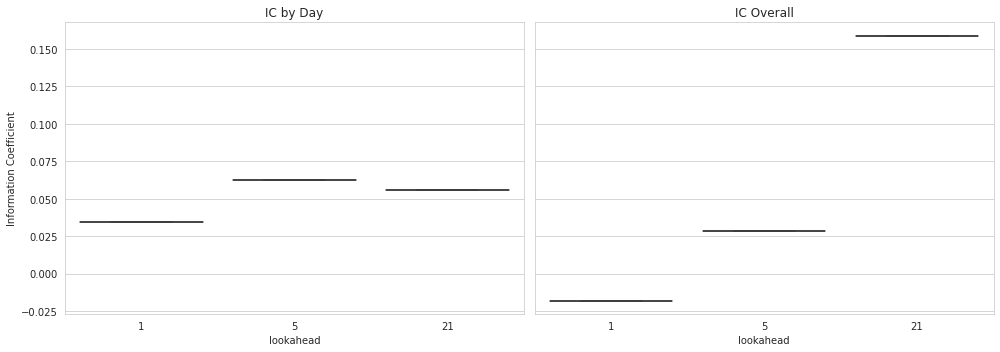

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharey=True)

# 일별 IC 값의 평균 그래프 
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')

# 모든 예측에 대한 IC 그래프 
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

### 최적 훈련/테스트 기간 길이 

1일 및 5일 수익률 예측의 경우, 짧은 훈련 및 테스트 길이가 일일 평균 IC 측면에서 더 나은 결과를 산출한다.

In [20]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic_by_day')))

,lookahead,train_length,test_length,ic_by_day,ic
0,1,252,63,0.034425,-0.017977
1,5,252,63,0.062667,0.028124
2,21,252,63,0.056143,0.158871


In [21]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

## LightGBM 모델 튜닝

노트북의 예제는 여러 설정에 걸쳐 반복시행되는데,  다양한 부분집합을 사용하는 모델 선택의 속도를 높이기 위해 선택적으로 랜덤 샘플을 사용한다.목표는 가능한 모든 조합을 시도하지 않고 가장 영향력 있는 파라미터를 식별하는 것이다.

In [22]:
def get_fi(model):
    """Return normalized feature importance as pd.Series"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### 하이퍼파라미터 옵션

`base_params`는 교차검증에 의해 영향을 받지 않는다.

In [23]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

다음 파라미터와 값을 선택해 최적의 모델을 선택한다. 자세한 내용은 교과서 참조.

In [24]:
# constraints on structure (depth) of each tree
# max_depths = [2, 3, 5, 7]
max_depths = [2, 3]

num_leaves_opts = [2 ** i for i in max_depths]

# min_data_in_leaf_opts = [250, 500, 1000]
min_data_in_leaf_opts = [250]

# weight of each new tree in the ensemble
# learning_rate_ops = [.01, .1, .3]
learning_rate_ops = [.01, .1]

# random feature selection
# feature_fraction_opts = [.3, .6, .95]
feature_fraction_opts = [.3]

In [25]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [26]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 4


### 훈련/테스트 기간 길이 

In [27]:
# lookaheads = [1, 5, 21]
lookaheads = [1]
label_dict = dict(zip(lookaheads, labels))

우리는 모델 훈련과 평가 시간을 절약하기 위해 63일 길이의 테스트 기간만 사용한다.

In [28]:
# train_lengths = [int(4.5 * 252), 252]
train_lengths = [252]
test_lengths = [63]

In [29]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 1


### 범주형 변수

LightGBM이 예상한 대로 0에서 시작하는 값을 정수 인코딩한다(범부형 코드가 $2^{32}$보다 작은 값을 가지는 한, 필요없지만, 경고를 피하기 위함).

In [30]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### 사용자 정의 손실함수: 정보계수 

In [31]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### 교차검증 실행

하이퍼파라미터 공간을 탐색하기 위해 조합해 테스트할 주요 파라미터에 대한 값을 지정한다. sklearn 라이브러리는 'RandomizedSearchCV'를 지원하여 지정된 분포로부터 랜덤 샘플링된 파라미터 조합의 부분 집합을 교차 검증한다. 
- 반복 횟수를 미리 지정하지 않고 결과를 만족하면 검색 프로세스를 중단할 수 있도록 성능을 모니터링할 수 있는 사용자 지정 버전을 구현할 것이다.

In [32]:
lgb_store = Path(results_path / 'tuning_lgb.h5')

In [33]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [34]:
label_dict = dict(zip(lookaheads, labels))

In [35]:
# num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_iterations = [10, 25, 50] 
num_boost_round = num_iterations[-1]

In [36]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [37]:
metric_cols

['learning_rate',
 'num_leaves',
 'feature_fraction',
 'min_data_in_leaf',
 't',
 'daily_ic_mean',
 'daily_ic_mean_n',
 'daily_ic_median',
 'daily_ic_median_n',
 '10',
 '25',
 '50']

우리는 6가지 CV 설정을 반복하고 결과 성과척도를 수집한다.

In [38]:
for lookahead, train_length, test_length in test_params:
    # 랜덤 그리드 검색 (randomized grid search)
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # 교차검증 구성 설정
    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    # 시계열 교차검증
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    
    # 이진 데이터 세트
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    
    # (셔플된) 하이퍼파라미터 조합에 대해 반복시행
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        
        # 폴드에 걸쳐 반복시행
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            
            # 훈련 부분집합을 선택
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                                       params=params).construct()
            
            # num_boost_round 만큼 모델 훈련
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)
            # 특성 중요도 기록
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # 예측 
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            
            # 각 폴드에 대한 예측 기록
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        
        # 폴드 결과 결합
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        
        # 일별 IC 계산
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()
        
        # 모든 예측에 걸쳐 IC 계산
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        
        # 성과 척도 수집
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        # 주어진 CV 실행과 하이퍼파라미터 조합에 대한 결과 저장
        metrics.to_hdf(lgb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(lgb_store, 'fi/' + key)
        cv_preds.to_hdf(lgb_store, 'predictions/' + key)

Lookahead:  1 | Train: 252 | Test: 63 | Params:   2 | Train configs: 1
	  0 | 00:00:14 ( 14) |  0.01 |   8 | 30% |  250 |  -0.07% | -0.04% |   10 |  0.22% |   50
	  1 | 00:00:24 ( 11) |  0.10 |   8 | 30% |  250 |   1.10% |  0.45% |   50 |  1.08% |   25


## CatBoost 모델 튜닝

유사한 프로세스를 CatBoost에 대해 반복한다.  CatBoost에 대한 자세한 내용은 [docs](https://catboost.ai/docs/concepts/about.html)를 참조하라.

### 하이퍼파라미터 옵션

In [39]:
param_names = ['max_depth', 'min_child_samples']

# max_depth_opts = [3, 5, 7, 9]
# min_child_samples_opts = [20, 250, 500]

# param_names = ['max_depth']

max_depth_opts = [3, 5]
min_child_samples_opts = [20, 250]

In [40]:
cv_params = list(product(max_depth_opts,
                         min_child_samples_opts))
n_params = len(cv_params)

### 훈련/테스트 기간 길이

In [41]:
# lookaheads = [1, 5, 21]
lookaheads = [1]
label_dict = dict(zip(lookaheads, labels))

In [42]:
# train_lengths = [int(4.5 * 252), 252]
train_lengths = [252]
test_lengths = [63]

In [43]:
test_params = list(product(lookaheads,
                           train_lengths,
                           test_lengths))

### 사용자 정의 손실함수

In [44]:
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

### 교차검증 실행

In [45]:
cb_store = Path(results_path / 'tuning_catboost.h5')

In [46]:
# num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
num_iterations = [10, 25, 50] 
num_boost_round = num_iterations[-1]

In [47]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [48]:
for lookahead, train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 1),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')

    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    cat_cols_idx = [outcome_data.columns.get_loc(c) for c in categoricals]
    catboost_data = Pool(label=outcome_data[label],     #catboost 데이터 만들기
                         data=outcome_data.drop(label, axis=1),
                         cat_features=cat_cols_idx)
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    key = f'{lookahead}/{train_length}/{test_length}'
    T = 0
    for p, param_vals in enumerate(cv_params_):
        params = dict(zip(param_names, param_vals))
        # uncomment if running with GPU
        # params['task_type'] = 'GPU'

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            train_set = catboost_data.slice(train_idx.tolist())

            model = CatBoostRegressor(**params)
            model.fit(X=train_set,
                      verbose_eval=False)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_names_]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, ntree_end=n)
                      for n in num_iterations}
            cv_preds.append(y_test.to_frame(
                'y_test').assign(**y_pred).assign(i=i))

        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
              for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n,
                             daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["max_depth"]:3.0f} | {params["min_child_samples"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)
        metrics.to_hdf(cb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(cb_store, 'daily_ic/' + key)
        cv_preds.to_hdf(cb_store, 'predictions/' + key)

Lookahead:  1 | Train: 252 | Test: 63 | Params:   4 | Train configs: 1
  0 | 00:10:01 (601) |   3 |  250 |   1.65% |  1.39% |   25 |  1.49% |   25
  1 | 00:25:54 (954) |   5 |  250 |   1.76% |  1.02% |   25 |  1.19% |   25
  2 | 00:35:54 (599) |   3 |   20 |   1.65% |  1.39% |   25 |  1.49% |   25
  3 | 00:51:46 (952) |   5 |   20 |   1.76% |  1.02% |   25 |  1.19% |   25
